# Using scEve to improve clustering

In [1]:
# Import libraries
import warnings 
warnings.simplefilter('ignore')

import scanpy as sc
import scparadise
import muon as mu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Recommendations about dataset 
Our models trained using shifted logarithm normalized data. <br>
We recommend shifted logarithm data normalization method to proper usage of our models: <br>
sc.pp.normalize_total(adata, target_sum=None) <br>
sc.pp.log1p(adata) <br>
adata.raw = adata

In [2]:
# Load example data from 10x Genomics
url = "https://cf.10xgenomics.com/samples/cell-exp/6.0.0/10k_PBMCs_TotalSeq_B_3p/10k_PBMCs_TotalSeq_B_3p_filtered_feature_bc_matrix.h5"
mdata = mu.read_10x_h5("dataset.h5", backup_url = url)
adata_adt = mdata.mod['prot'].copy()
adata = mdata.mod['rna'].copy()
adata.var_names_make_unique()
del mdata

In [3]:
# Create/Load AnnData
# adata = sc.read_10x_h5("filtered_feature_bc_matrix.h5")
# adata = sc.read_h5ad('adata.h5ad')

## Gene expression data processing

In [4]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [5]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

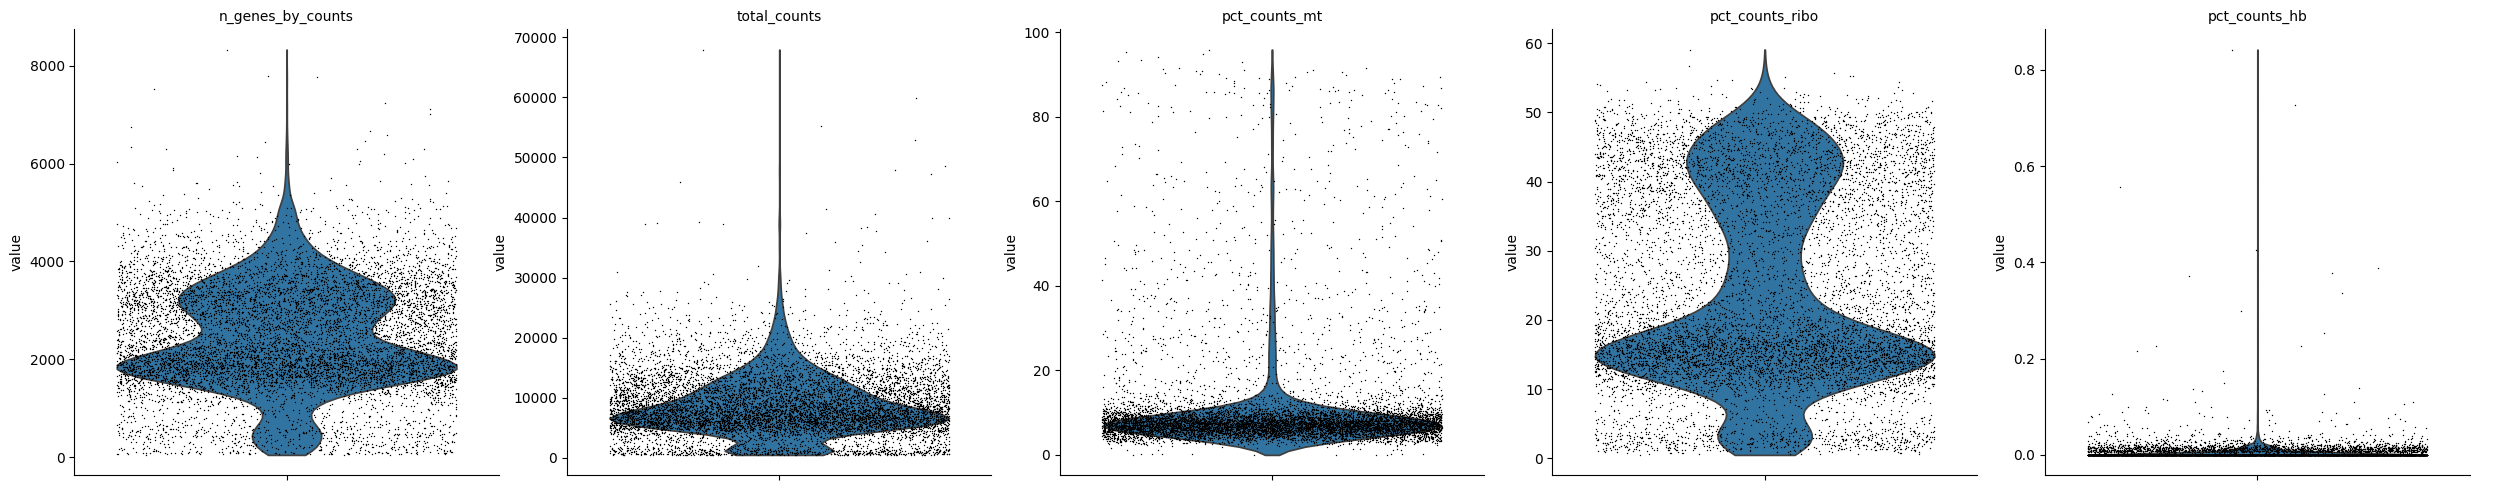

In [6]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", 'pct_counts_ribo', 'pct_counts_hb'],
    jitter=0.4, 
    multi_panel=True,
)

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [8]:
# Detect doublets
sc.pp.scrublet(adata)

In [9]:
# Remove doublets + other QC metrics
adata = adata[adata.obs['predicted_doublet'] == False]
sc.pp.filter_cells(adata, max_genes = 5000)
adata = adata[adata.obs['pct_counts_mt'] < 20]

## Normalization, HVG, neighbors, PCA, UMAP of RNA data

In [10]:
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalization
sc.pp.normalize_total(adata, target_sum=None)
sc.pp.log1p(adata) 
# scParadise use normalized data in adata.raw!!!
adata.raw = adata
# HVG
sc.pp.highly_variable_genes(adata, n_top_genes=1200)
# PCA
sc.tl.pca(adata)
# Nearest neighbors analysis
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15)
# UMAP
sc.tl.umap(adata, random_state=1)
# Clusterization
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_0.5')

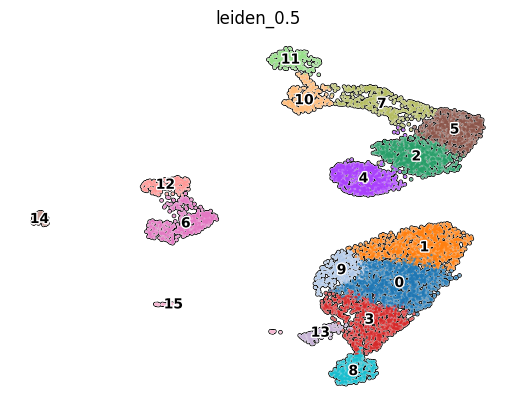

In [11]:
# Visualise clustering
sc.pl.embedding(adata, 
                color = [
                    'leiden_0.5'
                ],
                basis = 'X_umap',
                frameon = False,
                add_outline = True,
                legend_loc = 'on data',
                legend_fontsize = 10,
                legend_fontoutline = 2)

## Visualization of NK and T cell scores

To demonstrate the functionality of the scEve model, we use the classic problem of separating transcriptomically similar NK and T cells (specifically CD8+ cytotoxic T cells). <br> 
The second classic problem is the separation of CD4+ and CD8+ T cell subtypes (effector and memory cells), as well as other types of T cells. <br>
Below are the T and NK scores calculated based on the marker genes of these cell types.

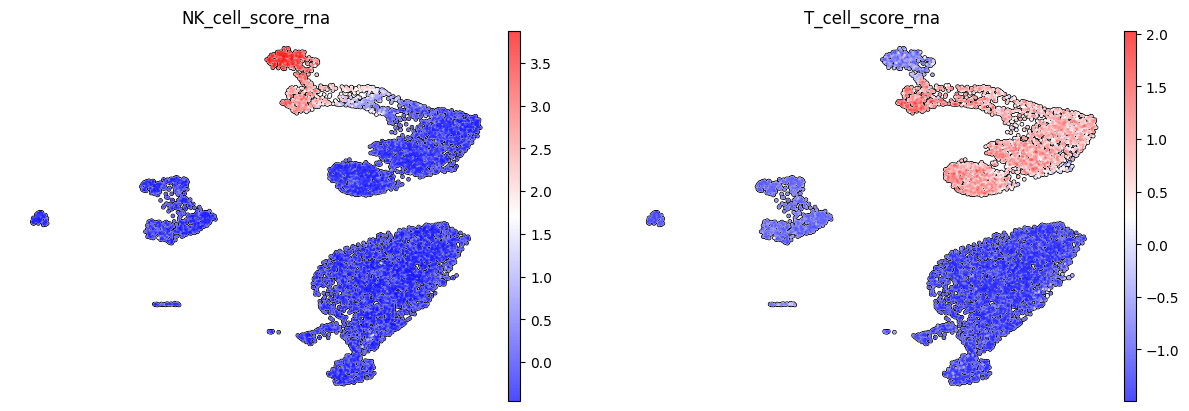

In [12]:
# Make NK cell score based on RNA expression
score_1 = 'NK_cell_score_rna'
markers = ['GNLY', 'NKG7', 'KLRF1']
sc.tl.score_genes(adata, markers, score_name=score_1)

# Make T cell score based on RNA expression
score_2 = 'T_cell_score_rna'
markers = ['CD3E', 'CD3G', 'CD3D']
sc.tl.score_genes(adata, markers, score_name=score_2)

# Visualize scores
sc.pl.umap(
    adata, 
    color = [score_1, 
             score_2
            ], 
    cmap = "bwr", 
    frameon = False,
    add_outline = True,
    ncols = 2
)

(47710.846399661226, 0.5454467882345289)

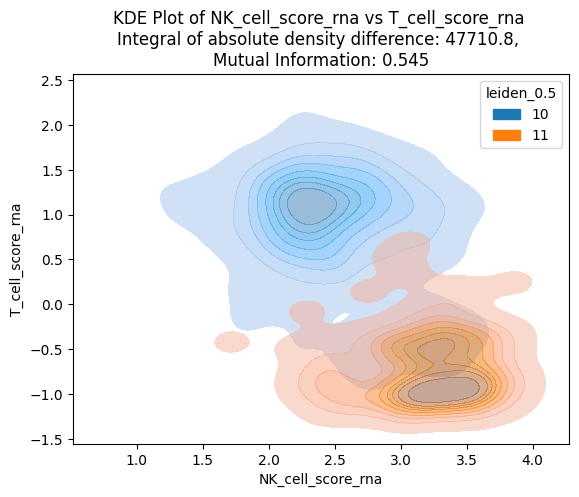

In [13]:
# Calculate Integral of absolute density difference and Mutual information
scparadise.scnoah.clust_diff(
    adata,
    groupby = 'leiden_0.5',
    group1 = '11',
    group2 = '10',
    score1 = 'NK_cell_score_rna',
    score2 = 'T_cell_score_rna'
)

Using RNA data, it is not possible to clearly define the cell type of cluster 10 (they can be either NK cells or T cells). <br>

The KDE plot also shows an overlap between 10 and 11 clusters based on NK and T scores calculated using RNA data. 

## Observed ADT preprocessing

In [14]:
adata_adt = adata_adt[adata.obs_names]
adata_adt.obsm['X_umap'] = adata.obsm['X_umap']

In [15]:
mu.prot.pp.clr(adata_adt)

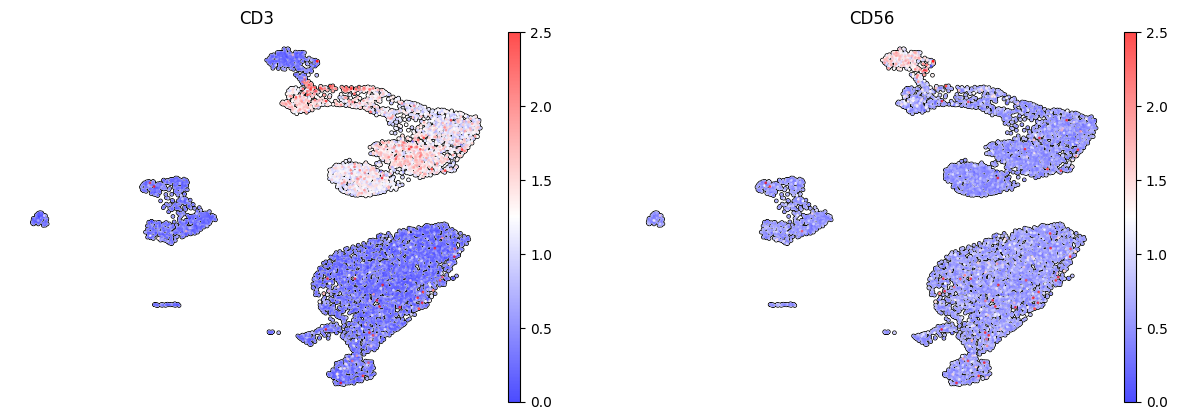

In [16]:
# Visualise CD3 and CD56
# CD3 - T cell marker
# CD56 - NK cell marker
sc.pl.embedding(adata_adt, 
                color = [
                    'CD3',
                    'CD56'
                ],
                basis = 'X_umap',
                frameon = False,
                add_outline = True,
                cmap = 'bwr',
                ncols = 2,
                vmax = 2.5
               )

Using the observed proteins, a clear boundary can be seen between NK cells and T cells.

## scParadise prediction (scEve + scAdam)

To clearly differentiate cell types, you can add a new modality (abundance of surface proteins) using scEve models. <br> 
You can also use scAdam models to predict cell types.

In [17]:
# Available models for cell type annotation
df_eve = scparadise.sceve.available_models()
df_eve

RMSE - Root Mean Squared Error
MSE - Mean Squared Error
MAE - Mean Absolute Error



Tissue/Model name                                        Description  \
0            Human_PBMC_3p  Peripheral blood mononuclear cells of healthy ...   
1            Human_PBMC_5p  Peripheral blood mononuclear cells of healthy ...   
2               Human_BMMC     Bone marrow mononuclear cell of healthy adults   
3              Human_Heart  Human heart CITE-seq analysis of healthy and d...   
4  Mouse_Spleen_Lymph_node  Spleen and Lymph node immune cells of healthy ...   

  Suspension   RMSE    MAE  Number of Proteins  
0      cells  0.305  0.226                 224  
1      cells  0.308  0.225                  54  
2      cells  0.706  0.454                 134  
3      cells  0.399  0.287                 270  
4      cells  0.313  0.214                 113

In [18]:
# Download model for cell type prediction
scparadise.sceve.download_model(model_name = 'Human_PBMC_3p', 
                                save_path = '')

In [19]:
# Predict cell types using trained scEve model
mdata = scparadise.sceve.predict(adata, 
                                 path_model = 'Human_PBMC_3p_scEve',
                                 return_mdata = True)

Successfully loaded list of genes used for training model

Successfully loaded list of features used for training model

Successfully loaded model



In [20]:
# Available models for cell type annotation
df_adam = scparadise.scadam.available_models()
# Show models related to humans
df_adam_human = df_adam[df_adam['Tissue/Model name'].str.startswith('Human_')]
df_adam_human

Tissue/Model name  \
0                Human_PBMC   
1                Human_BMMC   
2               Human_Heart   
3                Human_Lung   
4         Human_Lung_Cancer   
5   Human_oropharyngeal_SCC   
6         Human_Brain_atlas   
7        Human_Brain_SEA_AD   
8          Human_CC_Dev_RNA   
9         Human_CC_Dev_ATAC   
10        Human_Kidney_cell   
11     Human_Kidney_nucleus   
12        Human_Retina_cell   
13     Human_Retina_nucleus   

                                          Description Suspension  Accuracy  \
0   Peripheral blood mononuclear cells of healthy ...      cells     0.979   
1      Bone marrow mononuclear cell of healthy adults      cells     0.947   
2   Human heart CITE-seq analysis of healthy and d...      cells     0.957   
3                          Core Human Lung Cell Atlas      cells     0.965   
4       Extended single-cell lung cancer atlas (LuCA)      cells     0.937   
5   Oropharyngeal HPV+/HPV- squamous cell carcinom...      cells     0.972   
6                         Human Brain Cell Atlas v1.0     nuclei     0.998   
7        Seattle Alzheimer’s Disease Brain Cell Atlas     nuclei     0.997   
8   Multi-omic profiling of the developing human c...     nuclei     0.974   
9   Multi-omic profiling of the developing human c...     nuclei     0.916   
10       scRNA-seq of the Adult Human Kidney (V. 1.5)      cells     0.974   
11       snRNA-seq of the Adult Human Kidney (V. 1.5)     nuclei     0.973   
12              Single cell atlas of the human retina      cells     0.984   
13           Single nucleus atlas of the human retina     nuclei     0.994   

    Balanced Accuracy  Number of Levels  
0               0.979                 3  
1               0.942                 3  
2               0.956                 2  
3               0.964                 5  
4               0.936                 3  
5               0.968                 2  
6               0.998                 2  
7               0.997                 3  
8               0.975                 2  
9               0.912                 2  
10              0.974                 3  
11              0.972                 3  
12              0.979                 4  
13              0.994                 2

In [21]:
scparadise.scadam.download_model(model_name = 'Human_PBMC', 
                                 save_path = '')

In [22]:
mdata.mod['rna'] = scparadise.scadam.predict(mdata.mod['rna'], 
                                             path_model = 'Human_PBMC_scAdam')
mdata.update()

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully added predicted celltype_l2 and cell type probabilities
Successfully added predicted celltype_l3 and cell type probabilities


## Clusterization and UMAP using imputed adt (abundance of surface proteins)

Next, we recommend using only highly correlated proteins for PCA calculation. Among the lowly correlated proteins, there are also antibodies that poorly bound to cells in the training dataset.

In [23]:
scparadise.sceve.high_corr(mdata.mod['adt'], 
                           path_model = 'Human_PBMC_3p_scEve',
                           threshold = 0.6,
                           subset = False)

In [24]:
# PCA using only highly correlated proteins
mdata.mod['adt'].var['highly_variable'] = mdata.mod['adt'].var['highly_correlated']
sc.tl.pca(mdata.mod['adt'], use_highly_variable = True)

In [25]:
# Concatenate PCA from rna and imputed adt
mdata.obsm["X_pca_concat"] = np.hstack([mdata.mod["rna"].obsm["X_pca"][:, :15], mdata.mod["adt"].obsm["X_pca"][:, :5]])
mdata.update()

In [26]:
# Nearest neighbors analysis
sc.pp.neighbors(mdata, n_neighbors = 10, n_pcs = 20, use_rep = "X_pca_concat")
# UMAP
sc.tl.umap(mdata, random_state = 1)
# Clusterization
sc.tl.leiden(mdata, resolution = 0.5, key_added='leiden_0.5')

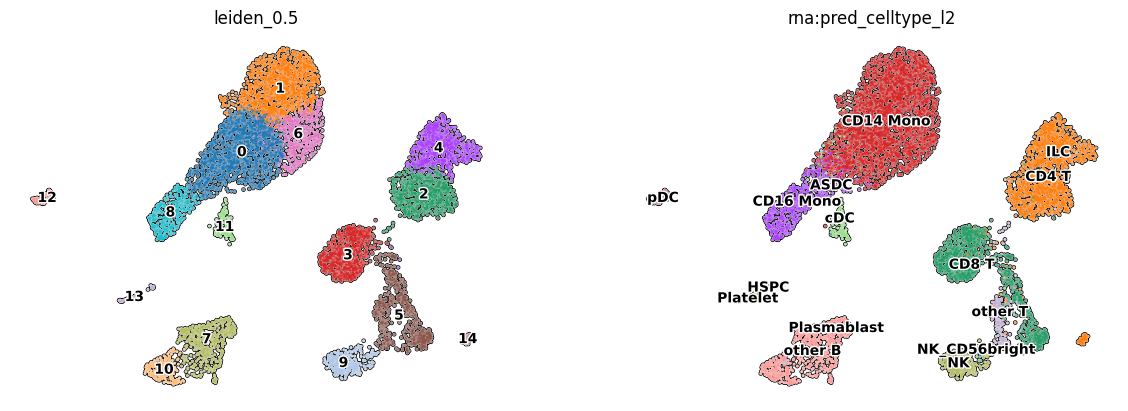

In [27]:
# Visualise clusterization on UMAP calculated using rna and imputed adt PCA
mu.pl.embedding(mdata, 
                color = [
                    'leiden_0.5',
                    'rna:pred_celltype_l2'
                ],
                basis = 'X_umap',
                frameon = False,
                add_outline = True,
                legend_loc = 'on data',
                legend_fontsize = 10,
                legend_fontoutline = 2
               )

In [28]:
# Select clusters of T cells
mdata_T_NK = mdata[mdata.obs['leiden_0.5'].isin(['2', '4', '14', '3', '5', '9'])].copy()

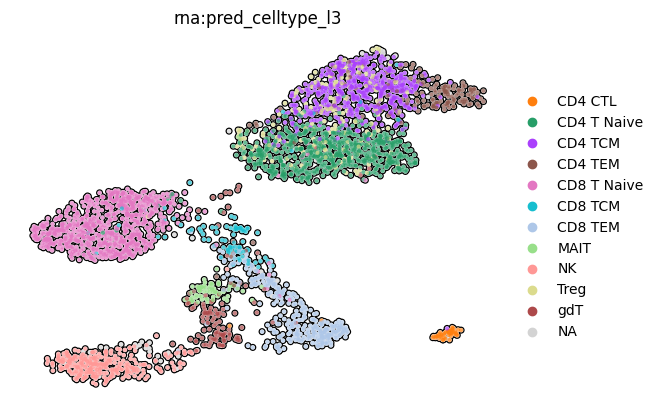

In [29]:
mu.pl.embedding(mdata_T_NK, 
                color = [
                    'rna:pred_celltype_l3'
                ],
                groups = ['CD4 T Naive',
                          'CD4 TCM',
                          'CD4 TEM',
                          'CD4 CTL',
                          'CD8 T Naive',
                          'CD8 TCM',
                          'CD8 TEM',
                          'Treg',
                          'MAIT',
                          'gdT',
                          'NK'],
                basis = 'X_umap',
                frameon = False,
                add_outline = True,
                legend_loc = 'right margin',
                legend_fontsize = 10,
                legend_fontoutline = 2
               )
# NA - some rare cell types (double negative T cells, NK CD56 bright, proliferative T and NK cells)

scEve surface protein prediction allows for a clear separation of T and NK cell subtypes, as seen in the resulting clustering and UMAP.

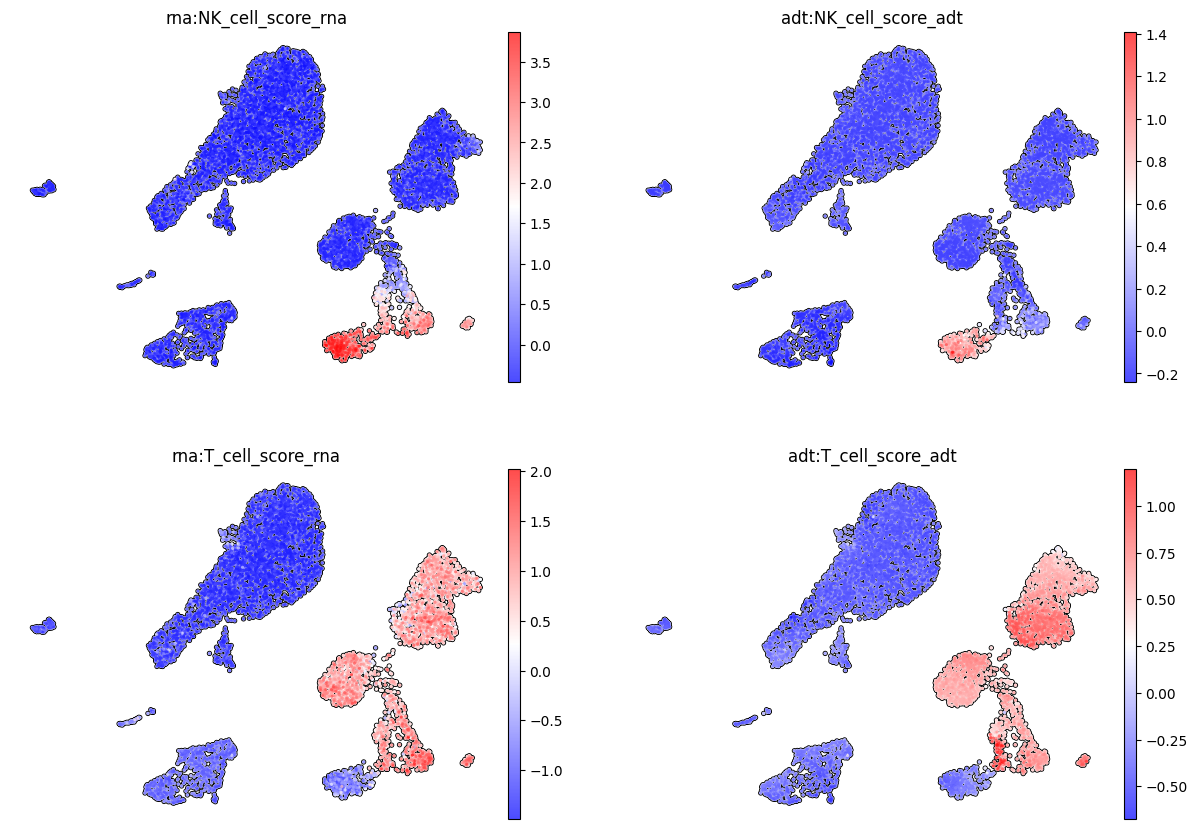

In [30]:
# Make NK cell score based on imputed proteins
score_3 = 'NK_cell_score_adt'
markers = ['adt_CD56-1_pred', 'adt_CD56-2_pred', 'adt_CD158b_pred', 'adt_CD158_pred', 'adt_CD335_pred']
sc.tl.score_genes(mdata.mod['adt'], markers, score_name = score_3)

# Make T cell score based on imputed proteins
score_4 = 'T_cell_score_adt'
markers = ['adt_CD3-1_pred','adt_CD3-2_pred']
sc.tl.score_genes(mdata.mod['adt'], markers, score_name = score_4)
mdata.update()

# Visualize scores
sc.pl.umap(
    mdata, 
    color = ['rna:' + score_1, # RNA based NK score
             'adt:' + score_3, # ADT based NK score
             'rna:' + score_2, # RNA based T score
             'adt:' + score_4  # ADT based T score
            ], 
    cmap = "bwr", 
    frameon = False,
    add_outline = True,
    s = 20,
    ncols = 2
)

(184877.1423779082, 0.8288763456762659)

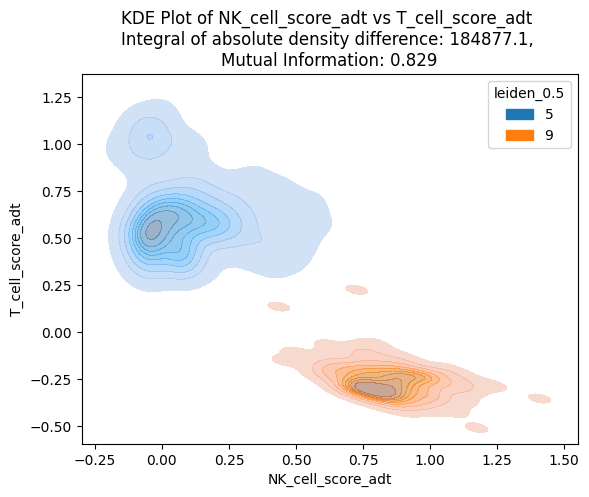

In [31]:
for i in ['adt', 'rna']:
    mdata.obs[f'T_cell_score_{i}'] = mdata.mod['adt'].obs[f'T_cell_score_{i}']
    mdata.obs[f'NK_cell_score_{i}'] = mdata.mod['adt'].obs[f'NK_cell_score_{i}']

scparadise.scnoah.clust_diff(
    mdata,
    groupby = 'leiden_0.5',
    group1 = '9',
    group2 = '5',
    score1 = 'NK_cell_score_adt',
    score2 = 'T_cell_score_adt'
)

The KDE plot also shows an absence of overlap between 5 and 9 clusters based on NK and T scores calculated using imputed surface protein data. <br>

Integral of absolute density difference increased from 47710 to 184877. <br>

Mutual information increased from 0.545 to 0.829. <br>

Each metric follows the principle that the higher the value, the better the clusters separate the selected scores.

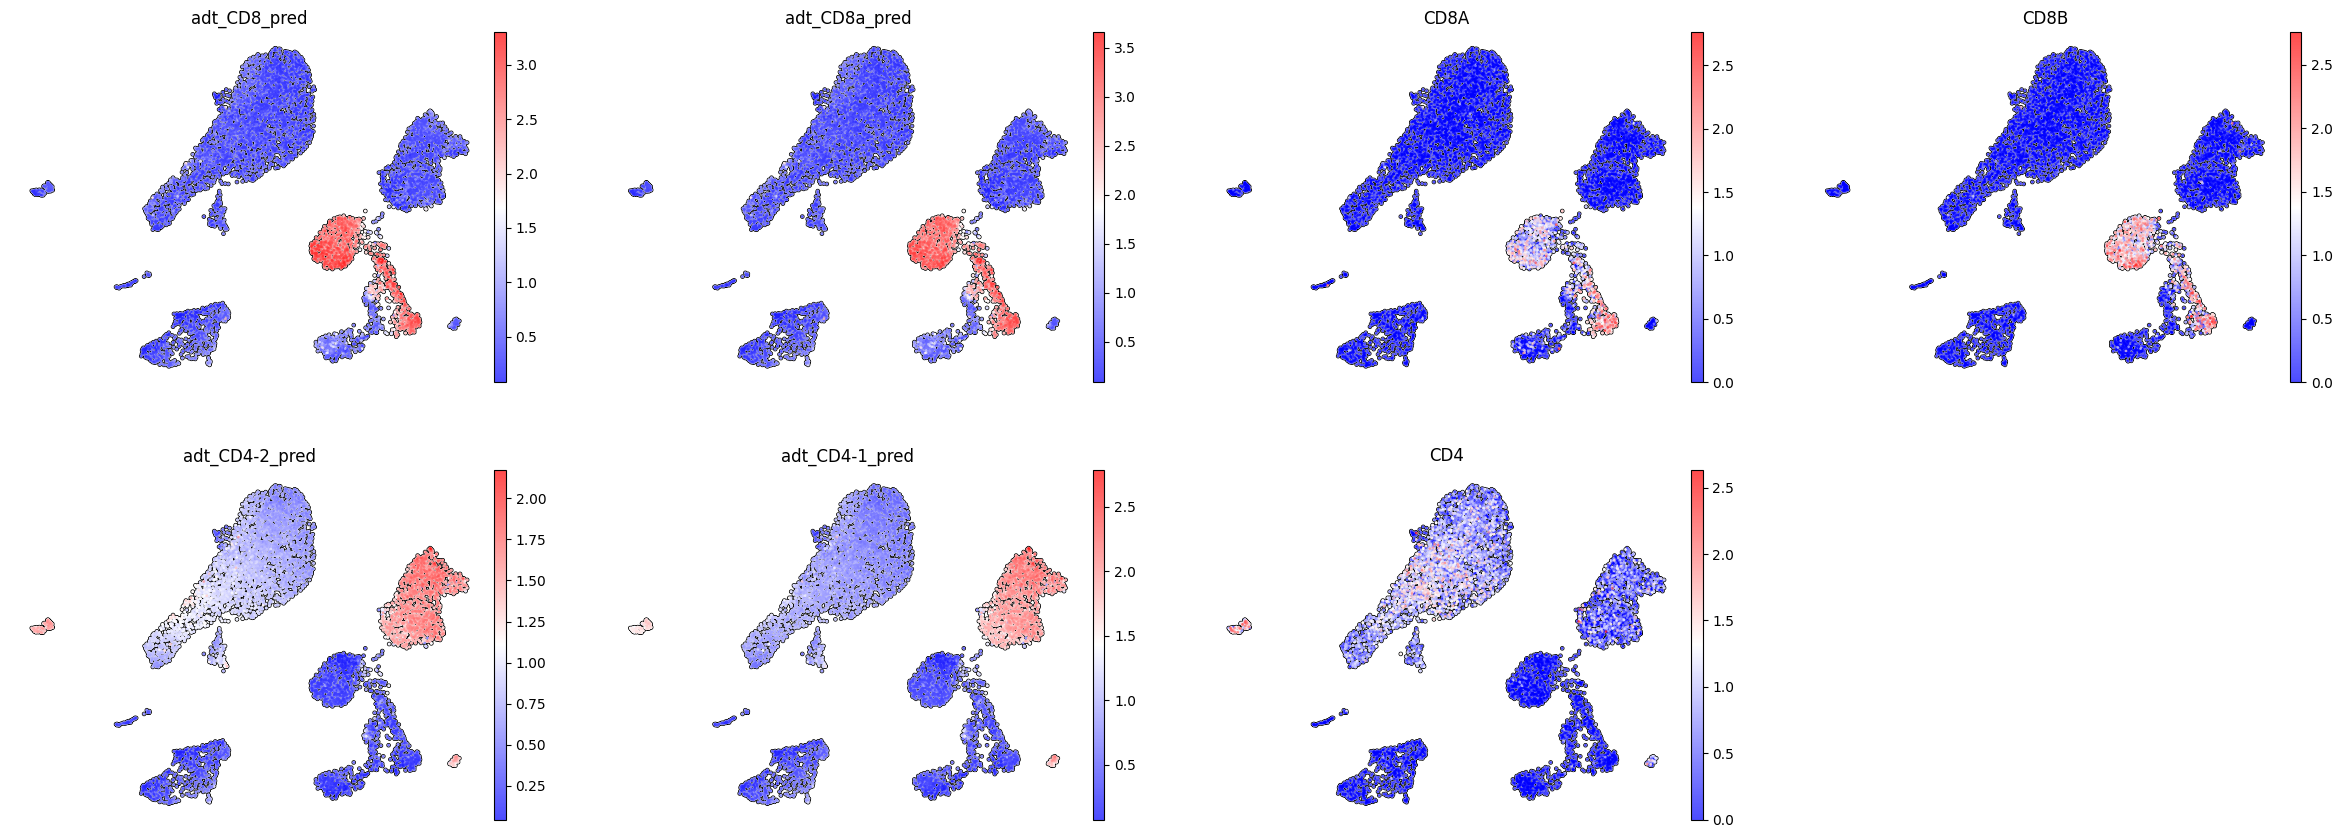

In [32]:
# Visualize RNA and ADT markers of T cell subtypes
mu.pl.embedding(mdata, 
                color = [
                    'adt_CD8_pred', 
                    'adt_CD8a_pred',
                    'CD8A',
                    'CD8B',
                    'adt_CD4-2_pred', 
                    'adt_CD4-1_pred',
                    'CD4'
                ],
                basis = 'X_umap',
                frameon = False,
                add_outline = True,
                cmap = 'bwr',
                ncols = 4
               )

## Imputed surface proteins facilitates cell type annotation

In [33]:
# Marker genes
markers_dict = {
    "B": ["CD79A", "MS4A1", 'adt_CD19_pred', 'adt_CD20_pred'],
    "plasmacytoid DC": ["IRF7", "IRF8", 'adt_CD304_pred', 'adt_CD303_pred'],
    "classical DC": ["FCER1A", "adt_CD1c_pred"],
    "CD14+ Monocytes": ["CD14", 'adt_CD14_pred'],
    "CD16+ Monocytes": ["FCGR3A", 'adt_CD16_pred'],
    "NK": ["GNLY", "NKG7", 'adt_CD56-1_pred', 'adt_CD56-2_pred'],
    "CD4 T": ["CD4", 'adt_CD4-1_pred', 'adt_CD4-2_pred'],
    "CD8 T": ["CD8A", 'CD8B', 'adt_CD8_pred', 'adt_CD8a_pred',],
    "Platelet": ["PPBP", 'PF4'],
    "HSPC": ['CD34', 'GATA2', 'adt_CD34_pred']
}

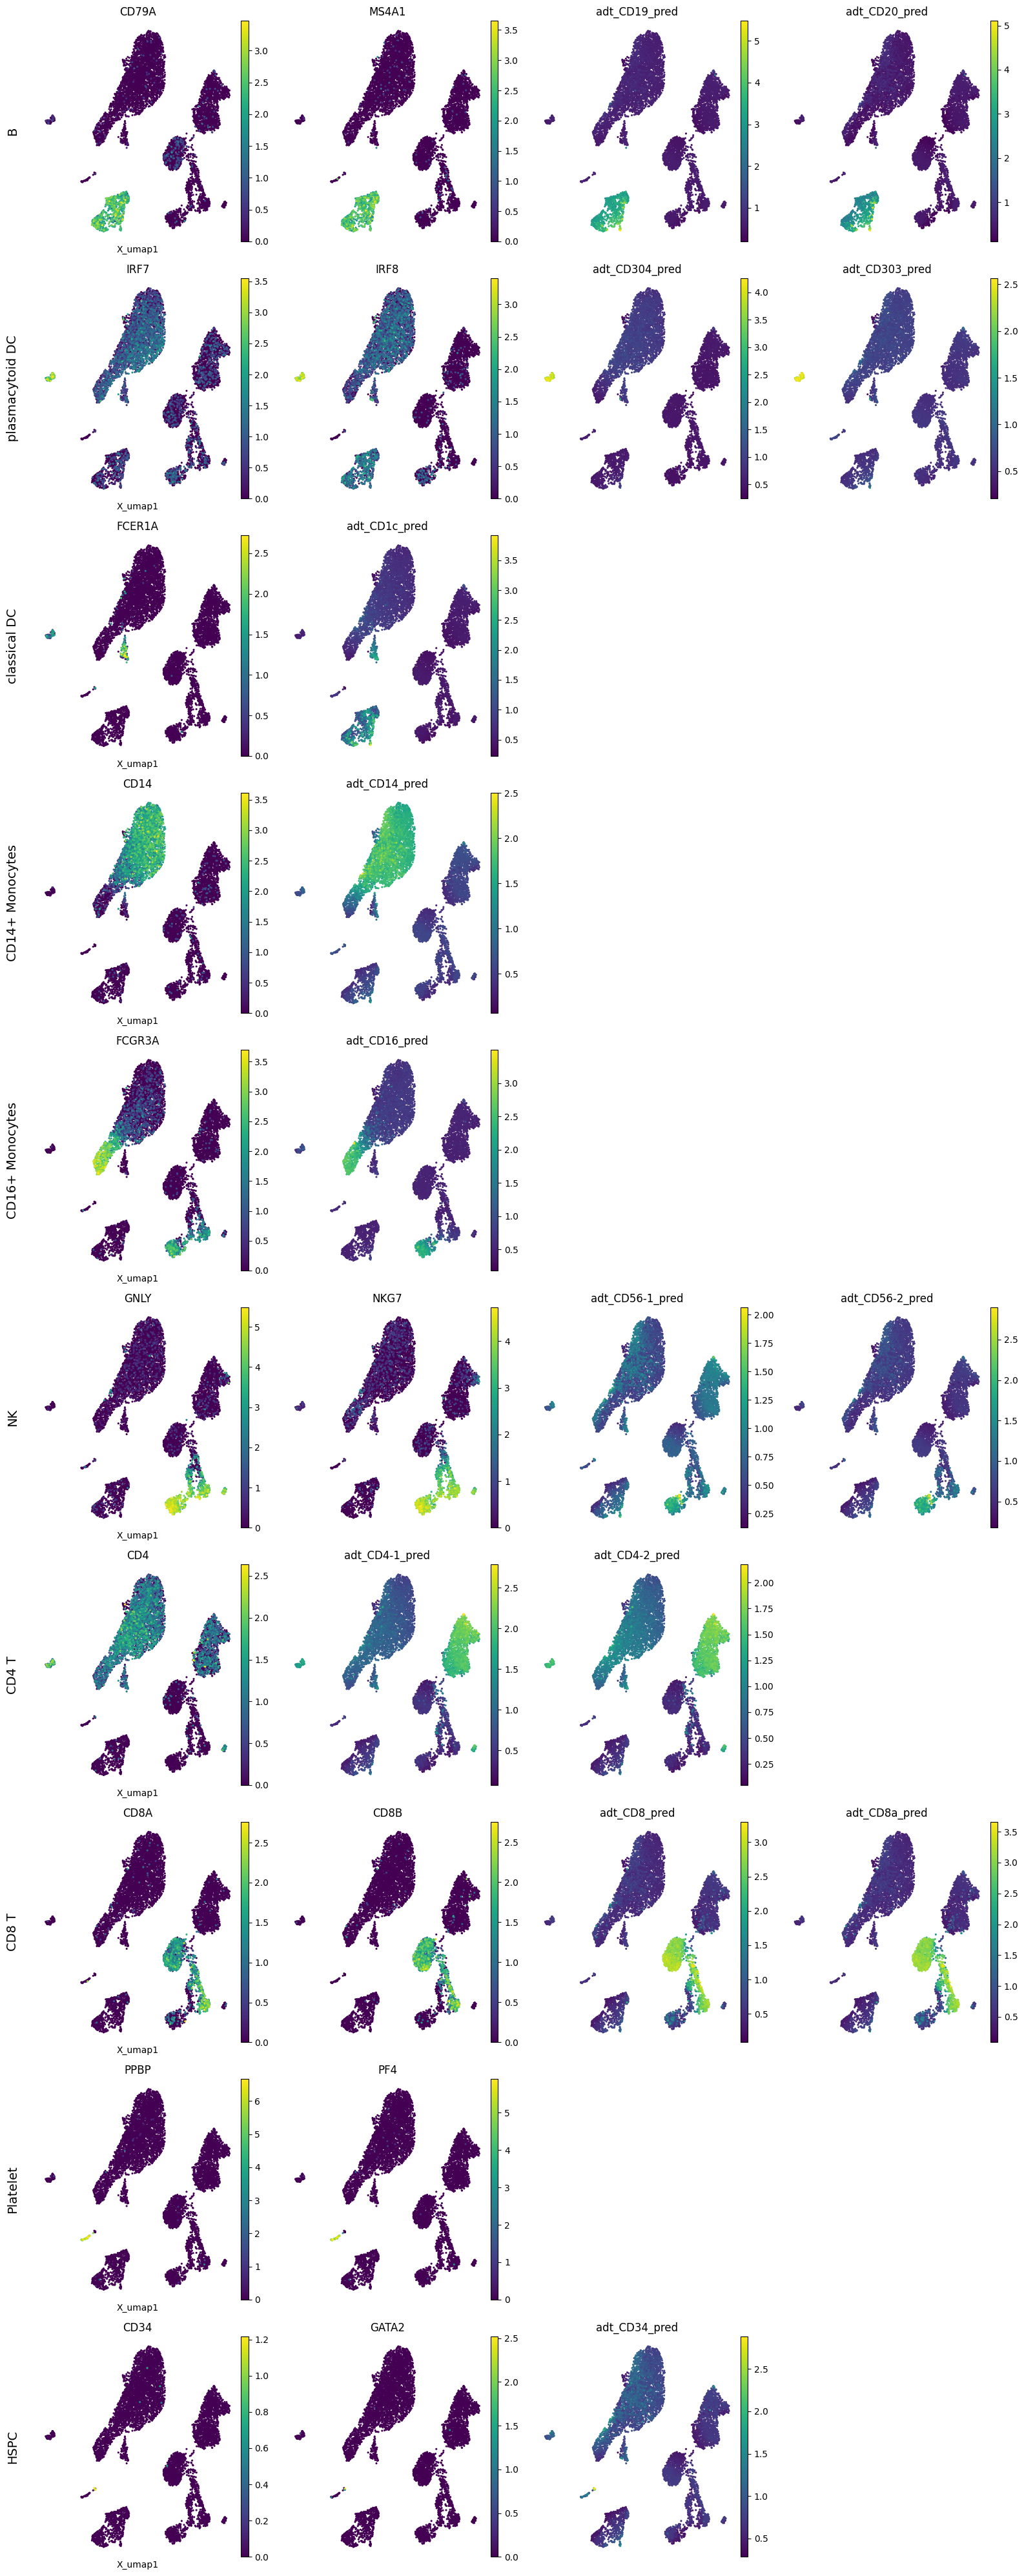

In [34]:
# Make Axes
# Number of needed rows and columns (based on the row with the most columns)
nrow = len(markers_dict)
ncol = max([len(vs) for vs in markers_dict.values()])
fig, axs = plt.subplots(nrow, ncol, figsize=(4 * ncol, 4 * nrow))
# Plot expression for every marker on the corresponding Axes object
for row_idx, (cell_type, markers) in enumerate(markers_dict.items()):
    col_idx = 0
    for marker in markers:
        ax = axs[row_idx, col_idx]
        mu.pl.umap(mdata, color=marker, ax=ax, show=False, frameon=False, s=20)
        # Add cell type as row label - here we simply add it as ylabel of
        # the first Axes object in the row
        if col_idx == 0:
            # We disabled axis drawing in UMAP to have plots without background and border
            # so we need to re-enable axis to plot the ylabel
            ax.axis("on")
            ax.tick_params(
                top="off",
                bottom="off",
                left="off",
                right="off",
                labelleft="on",
                labelbottom="off",
            )
            ax.set_ylabel(cell_type + "\n", rotation=90, fontsize=14)
            ax.set(frame_on=False)
        col_idx += 1
    # Remove unused column Axes in the current row
    while col_idx < ncol:
        axs[row_idx, col_idx].remove()
        col_idx += 1
# Alignment within the Figure
fig.tight_layout()

In [35]:
mdata.write_h5mu('pbmc_mdata.h5mu')

In [36]:
pip list

Package                     Version
--------------------------- --------------
absl-py                     2.1.0
accelerate                  1.4.0
adjustText                  1.3.0
aiobotocore                 2.5.4
aiohappyeyeballs            2.4.2
aiohttp                     3.10.8
aioitertools                0.12.0
aiosignal                   1.3.1
airr                        1.5.1
alembic                     1.13.3
anndata                     0.10.8
annoy                       1.17.3
anyio                       4.6.0
argon2-cffi                 23.1.0
argon2-cffi-bindings        21.2.0
array_api_compat            1.8
arrow                       1.3.0
asciitree                   0.3.3
asttokens                   2.4.1
async-lru                   2.0.4
async-timeout               4.0.3
attrs                       24.2.0
awkward                     2.7.1
awkward_cpp                 42
babel                       2.16.0
bamnostic                   1.1.10
bbknn                       1.6.